In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets

In [4]:
BATCH_SIZE  =32
mnist_transforms = transforms.Compose([transforms.ToTensor()])
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True, transform=mnist_transforms)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=True, transform=mnist_transforms)
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

all_batches = []
all_labels =[]

torch.manual_seed(10)
for x,y in train_dataloader:
    bs = x.shape[0]
    all_batches.append(x.flatten().reshape(bs,784))
    all_labels.append(y)

all_batches = torch.cat(all_batches,dim=0)
all_labels = torch.cat(all_labels,dim=0)

print(all_batches.shape)

100%|██████████| 9.91M/9.91M [00:01<00:00, 7.54MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 253kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.38MB/s]


torch.Size([54000, 784])


In [111]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,2)
              # Bottleneck
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Normalize output
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self,x):
        return self.encoder(x)


In [14]:
selected_classes = [3, 7]
indices = [i for i, (_, label) in enumerate(train_dataset) if label in selected_classes]
custom_mnist = Subset(train_dataset, indices)

train_dataloader= DataLoader(custom_mnist,batch_size=64,shuffle=True)

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 30

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_dataloader:
        images = images.view(images.size(0), -1).to(device) 
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images) 
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.4f}")


Epoch [1/30], Loss: 0.0617
Epoch [2/30], Loss: 0.0431
Epoch [3/30], Loss: 0.0377
Epoch [4/30], Loss: 0.0359
Epoch [5/30], Loss: 0.0348
Epoch [6/30], Loss: 0.0344
Epoch [7/30], Loss: 0.0339
Epoch [8/30], Loss: 0.0338
Epoch [9/30], Loss: 0.0338
Epoch [10/30], Loss: 0.0337
Epoch [11/30], Loss: 0.0335
Epoch [12/30], Loss: 0.0333
Epoch [13/30], Loss: 0.0333
Epoch [14/30], Loss: 0.0331
Epoch [15/30], Loss: 0.0331
Epoch [16/30], Loss: 0.0330
Epoch [17/30], Loss: 0.0329
Epoch [18/30], Loss: 0.0329
Epoch [19/30], Loss: 0.0330
Epoch [20/30], Loss: 0.0328
Epoch [21/30], Loss: 0.0326
Epoch [22/30], Loss: 0.0332
Epoch [23/30], Loss: 0.0330
Epoch [24/30], Loss: 0.0327
Epoch [25/30], Loss: 0.0324
Epoch [26/30], Loss: 0.0322
Epoch [27/30], Loss: 0.0320
Epoch [28/30], Loss: 0.0320
Epoch [29/30], Loss: 0.0319
Epoch [30/30], Loss: 0.0318


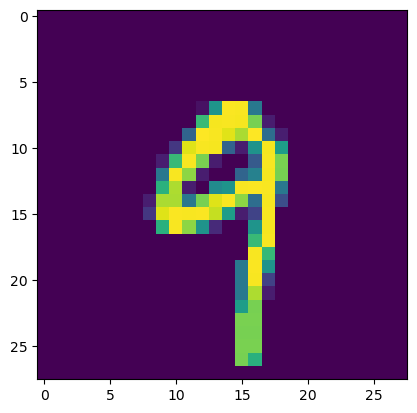

In [113]:
plt.imshow(val_dataset.__getitem__(99)[0].view(1,-1).reshape(28,28))

In [127]:
import pandas as pd
import numpy as np

In [124]:
v = []
c = []
for i,item in enumerate(val_dataset):
    v.append(model.encode(item[0].view(1,-1).to(device)).detach().cpu().numpy())
    c.append(item[1])
#model.encode(val_dataset.__getitem__(0)[0].view(1,-1).to(device))

In [ ]:
df = pd.DataFrame(np.vstack(v))
df['c'] = c

,0,1,c
0,1.478350,-0.889983,7
1,0.231463,1.286198,1
2,-0.484056,-0.174924,9
3,2.267948,8.568305,2
4,-5.306480,-5.150798,0


<Axes: xlabel='0', ylabel='1'>

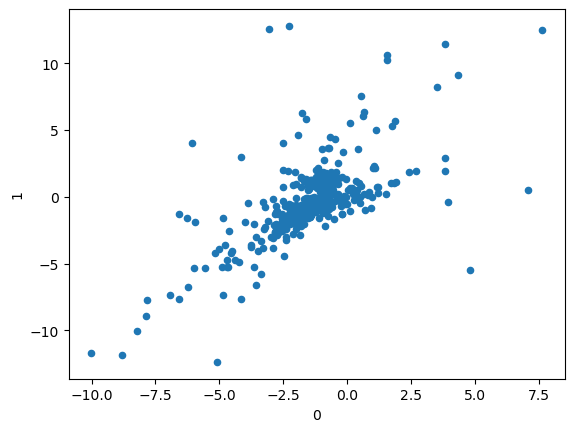

In [156]:
df[df['c']==8].iloc[:,:2].plot.scatter(x=0,y=1)

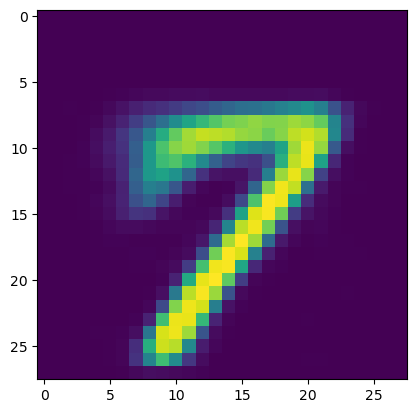

In [116]:
plt.imshow(model.forward(val_dataset.__getitem__(0)[0].view(1,-1).to(device)).reshape(28,28).detach().cpu().numpy())

In [ ]:
model.forward(val_dataset.__getitem__(10)[0].view(1,-1).to(device))

torch.Size([1, 784])